# DEMO AND TUTORIAL FOR LES FURNITURES

### Setting directory

In [1]:
import os
dirmain = os.getcwd()
print(dirmain)

/home/sa11799x/Documents/Test/ScenRec/ScenRec


### Cloning repo

In [2]:
!git clone https://github.com/AryamanSharma17/Grounded-Segment-Anything
#!pip install --upgrade timm
!git clone https://github.com/isl-org/ZoeDepth.git

fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
fatal: destination path 'ZoeDepth' already exists and is not an empty directory.


### Setting up Environments

In [3]:
# dirmain = dir + '/Grounded-Segment-Anything'
os.chdir(dirmain + '/Grounded-Segment-Anything')
%pip install -q -r requirements.txt
os.chdir(dirmain + '/Grounded-Segment-Anything/segment_anything')
%pip install -q .
os.chdir(dirmain + '/Grounded-Segment-Anything/GroundingDINO')
!pip install -q .
os.chdir(dirmain + '/Grounded-Segment-Anything')



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


New directory should be: Main Directory + Grounded-Segment-Anything

In [4]:
os.getcwd()

'/home/sa11799x/Documents/Test/ScenRec/ScenRec/Grounded-Segment-Anything'

In [5]:
import os, sys, gc

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert
import torch
import csv
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 

#ZoeDepth
from ZoeDepth.zoedepth.utils.misc import get_image_from_url, colorize
# %pip install timm==0.6.7

#Hugging Face
from huggingface_hub import hf_hub_download

## Loading Models

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    args.device = device
    model = build_model(args)
    
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

Grounding DINO

In [8]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device='cuda')

/home/sa11799x/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/sa11799x/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


SAM

In [9]:
if os.path.exists(dirmain+'/Grounded-Segment-Anything/sam_vit_b_01ec64.pth')==False:
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam_checkpoint = 'sam_vit_b_01ec64.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))


ZOE

In [10]:
os.chdir(dirmain + '/ZoeDepth')
zoe = torch.hub.load(".", "ZoeD_N", source="local", pretrained=True)
zoe = zoe.to(device)
os.chdir(dirmain)

img_size [384, 512]


Using cache found in /home/sa11799x/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


## Developing Functions

Bounding box and center generation with GDINO

In [11]:
def detect(image, text_prompt, model, box_threshold = 0.4, text_threshold = 0.2):
  boxes, logits, phrases = predict(
      model=model, 
      image=image, 
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB 
  return annotated_frame, boxes,phrases, logits


def gen_mask_Gd(image_source, boxes):
    h,w,_ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w,h,w,h]) 
    boxes_xyxy = box_convert(boxes =boxes_unnorm, in_fmt = "cxcywh", out_fmt = "xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0,x1,y1 = box
        mask[int(y0):int(y1), int(x0):int(x1),:] = 255
    return mask, boxes_xyxy, boxes_unnorm

def center(centerx,centery,detected_boxes):
    for i in range(len(detected_boxes)):
        centerx.append(int(detected_boxes[i][0] + detected_boxes[i][2])/2)
        centery.append(int(detected_boxes[i][1] + detected_boxes[i][3])/2)
    return centerx,centery

Segmentation with SAM

In [12]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cuda()

def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))
  

## Testing

Load Image

In [13]:
test_image = dirmain +'/Resource/Test_images/classroom_simple.jpg'
image_source, image = load_image(test_image)
source_image = Image.fromarray(image_source)

Resize Image

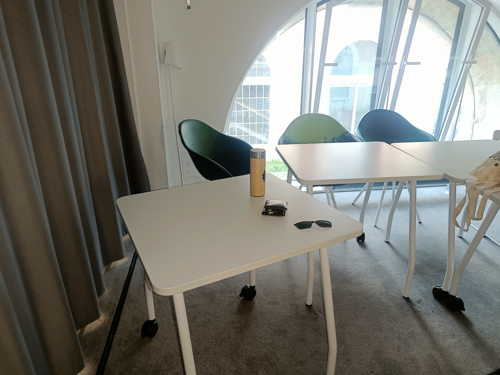

In [14]:
source_image = source_image.resize((int(source_image.width*500/source_image.width),int(source_image.height*500/source_image.width)))
image_source = np.asarray(source_image)
Image.fromarray(image_source)

In [15]:
image_source.shape

(375, 500, 3)

## OBJECT DETECTION AND CLASSIFICATION 

### Bounding box and class label generation with Grounding DINO

In [16]:
annotated_frame, detected_boxes,phrases, logits = detect(image, text_prompt="chair. table. sofa. door. window", model=groundingdino_model, box_threshold=0.5 )
anoim = Image.fromarray(annotated_frame)

/home/sa11799x/anaconda3/lib/python3.9/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sa11799x/anaconda3/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
2023-06-08 17:21:28.742186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 17:21:29.462371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


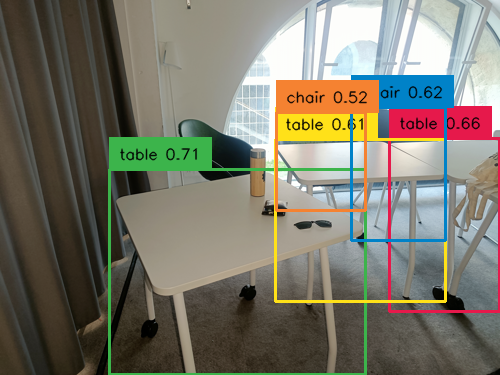

In [17]:
anoim

In [18]:
annotated_frame_wall, detected_boxes_wall,phrases_wall, logits_wall = detect(image, text_prompt="wall", model=groundingdino_model, box_threshold=0.25)
anoim_wall = Image.fromarray(annotated_frame_wall)

/home/sa11799x/anaconda3/lib/python3.9/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sa11799x/anaconda3/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Box Normalixation and snap to Image

In [19]:
mask,box_change,box_unnormalized = gen_mask_Gd(image_source,detected_boxes)
mask_wall,box_change_wall,box_unnormalized_wall = gen_mask_Gd(image_source,detected_boxes_wall)

Center Calculation for each bounding box

In [20]:
centerx = []
centery = []
centerwall_x=[]
centerwall_y=[]
centerx,centery = center(centerx,centery,box_change)
centerwall_x,centerwall_y = center(centerwall_x,centerwall_y,box_change_wall)


Visualization of bounding box

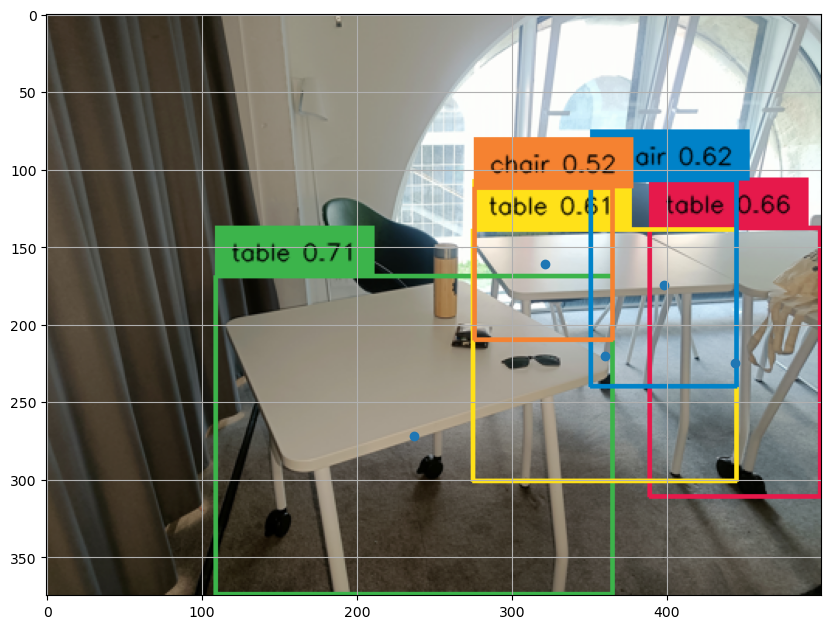

In [21]:
import matplotlib.pyplot as plt
c = np.array(["red","green","yellow","cyan","orange", "lime", "pink","Maroon", "purple", "aquamarine", "olive", "khakhi"])

plt.figure(figsize=(10,10))
scatter = plt.scatter(centerx,centery )
plt.imshow(anoim)
plt.grid()

## Mask Segmentation with SAM

Wall Segmentation

In [22]:
segmented_frame_masks_wall = segment(image_source, sam_predictor, boxes=detected_boxes_wall)
annotated_frame_with_mask_wall = draw_mask(segmented_frame_masks_wall[0][0], annotated_frame_wall)

In [23]:
gc.collect()
torch.cuda.empty_cache()

Single Mask Generation

In [24]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)


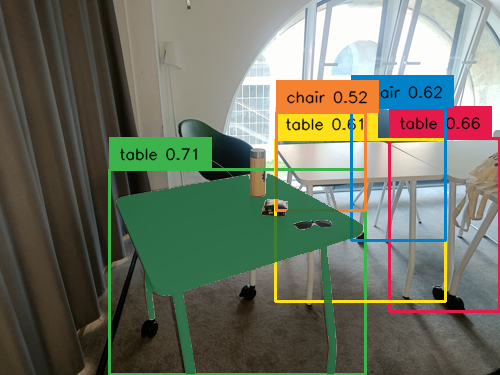

In [25]:
annotated_rame_with_mask = draw_mask(segmented_frame_masks[1][0], annotated_frame)
Image.fromarray(annotated_rame_with_mask)

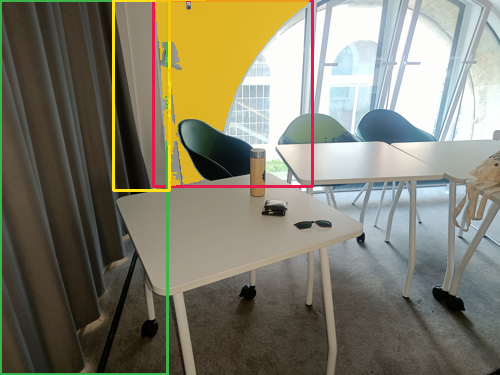

tensor(0.3394)


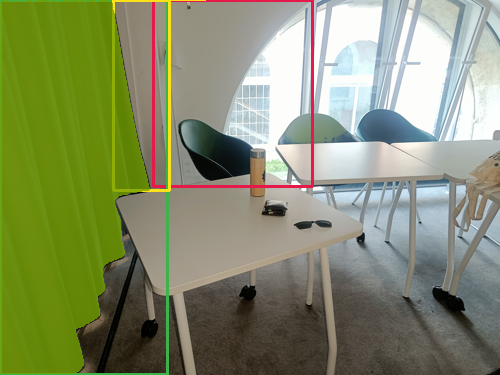

tensor(0.2763)


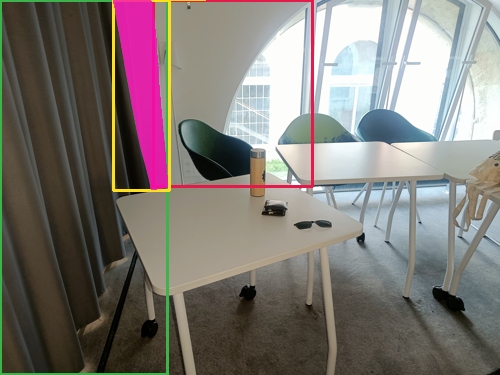

tensor(0.2760)


In [26]:
for i in range(len(phrases_wall)):
    f = draw_mask(segmented_frame_masks_wall[i][0], annotated_frame_wall)
    display(Image.fromarray(f))
    print(logits_wall[i])

In [27]:
mask_list_main = np.empty((len(phrases)),dtype= object)
mask_list_main.fill([])
for i in range(len(mask_list_main)):
    mask_list_main[i] = (segmented_frame_masks)[i][0].cpu().numpy()

In [28]:
mask_list_wall = np.empty((len(phrases_wall)),dtype= object)
mask_list_wall.fill([])
for i in range(len(mask_list_wall)):
    mask_list_wall[i] = (segmented_frame_masks_wall)[i][0].cpu().numpy()

Multiple Mask fusion and visualization

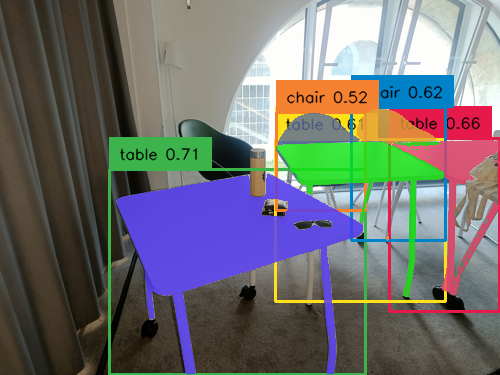

In [29]:
all_frames = annotated_frame
for i in range(len(segmented_frame_masks)):
  all_frames = draw_mask(segmented_frame_masks[i][0], all_frames)
Image.fromarray(all_frames)

Conversion into BW Mask image segregation

In [30]:
allmask = segmented_frame_masks[0][0].cpu().numpy()
for i in range(1,len(segmented_frame_masks)):
    allmask += segmented_frame_masks[i][0].cpu().numpy() 
allmask_image = Image.fromarray(allmask)

In [31]:
int_all_mask = np.array(allmask_image, dtype=np.uint8)

### EROSION

In [32]:
y_main = np.where(allmask==1)[0]
x_main = np.where(allmask==1)[1]
kernel = np.ones((2,2),np.uint8)
erosion_all = cv2.erode(int_all_mask, kernel, iterations=1)

In [33]:
# mask_list_erosion = np.empty((len(phrases),2),dtype=object)
# mask_list_erosion.fill([])
# for i in range(len(mask_list_erosion)):
#     mask_list_erosion[i][0] = cv2.erode(mask_list_main[i], kernel, iterations=1)
#     mask_list_erosion[i][1] = cv2.erode(mask_list_main[i], kernel, iterations=1)

In [34]:
y_erode = np.where(erosion_all==1)[0]
x_erode = np.where(erosion_all==1)[1]


Eroded Image

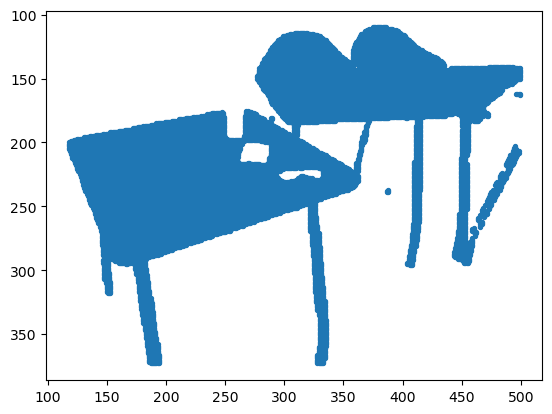

In [35]:
plt.scatter(x_erode,y_erode, 8)
plt.gca().invert_yaxis()

Actual Image

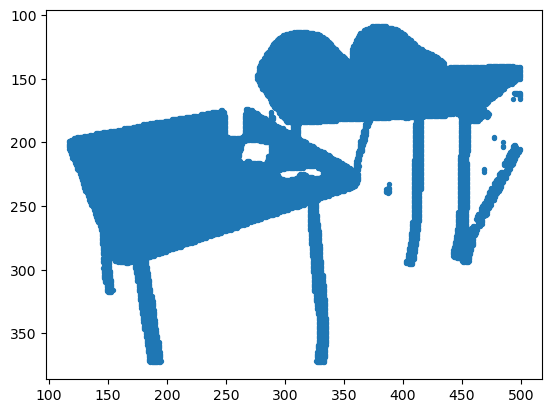

In [36]:
plt.scatter(x_main,y_main, 8)
plt.gca().invert_yaxis()

In [37]:
os.chdir(dirmain)

## Depth Estimation with ZOE

In [38]:
depth = zoe.infer_pil(source_image)

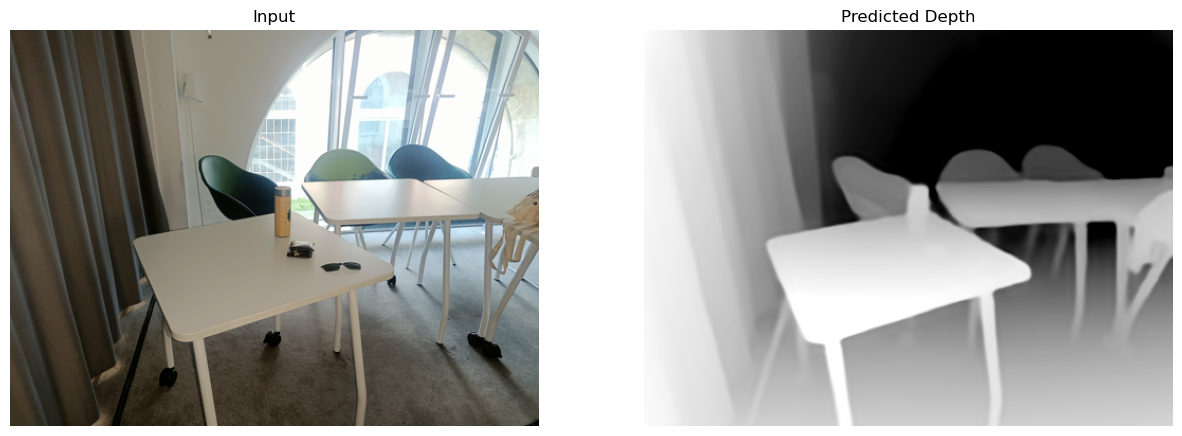

In [39]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2, figsize=(15,7))
for ax, im, title in zip(axs, [source_image, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

Depth Normalization [-8,8]

In [40]:
depth_nor = -5+((depth-np.min(depth))*(10/(np.max(depth)-np.min(depth))))
depth_nor_neg = 5-((depth-np.min(depth))*(10/(np.max(depth)-np.min(depth))))

Object Depth Calculation

In [41]:
depth_val = np.empty(len(phrases))
box_val = np.empty((len(phrases),8))
for i in range(len(phrases)):
    sum = []
    depth_temp = 0 
    buff = (np.where(mask_list_main[i] == True))
    for j in range(len(mask_list_main[i])):
        sum.append(depth_nor_neg[buff[0][j], buff[1][j]])
    depth_temp=np.median(sum)

    depth_val[i] = depth_temp


Wall Depth Calculation

In [42]:
bg_depth = np.empty(len(phrases_wall))
for i in range(len(phrases_wall)):
    sum = []
    depth_temp = 0 
    buff = (np.where(mask_list_wall[i] == True))
    for j in range(len(mask_list_wall[i])):
        sum.append(depth_nor[buff[0][j], buff[1][j]])
    depth_temp=np.median(sum)

    bg_depth[i] = depth_temp

In [43]:
wall_depth = -bg_depth.max()

## Creating output file for VR

In [44]:
data = np.empty((len(phrases),10),dtype=object)
data.fill([])

In [45]:
dict_fur = {'chair': 0, 'table': 1, 'sofa': 2, 'door': 3, 'window': 4}

In [46]:
for i in range(len(phrases)):
    for j in range(4):
        data[i][j] = (box_change[i][j])
    data[i][4] = centerx[i]
    data[i][5] = centery[i]
    data[i][6] = depth_val[i]
    data[i][7] = wall_depth
    data[i][9] = dict_fur[(phrases[i])]
    data[i][8] = logits[i].item()

Center = 4, 5

depth center = 6

Background Wall Depth = 7 

Class Confidence = 8

furniture type = 9 (`chair`: 0, `table`: 1, `sofa`: 2, `door`: 3, `window`: 4)


Local Co-ordinate System to Estimated System
![](<attachment:Mapping.png>)
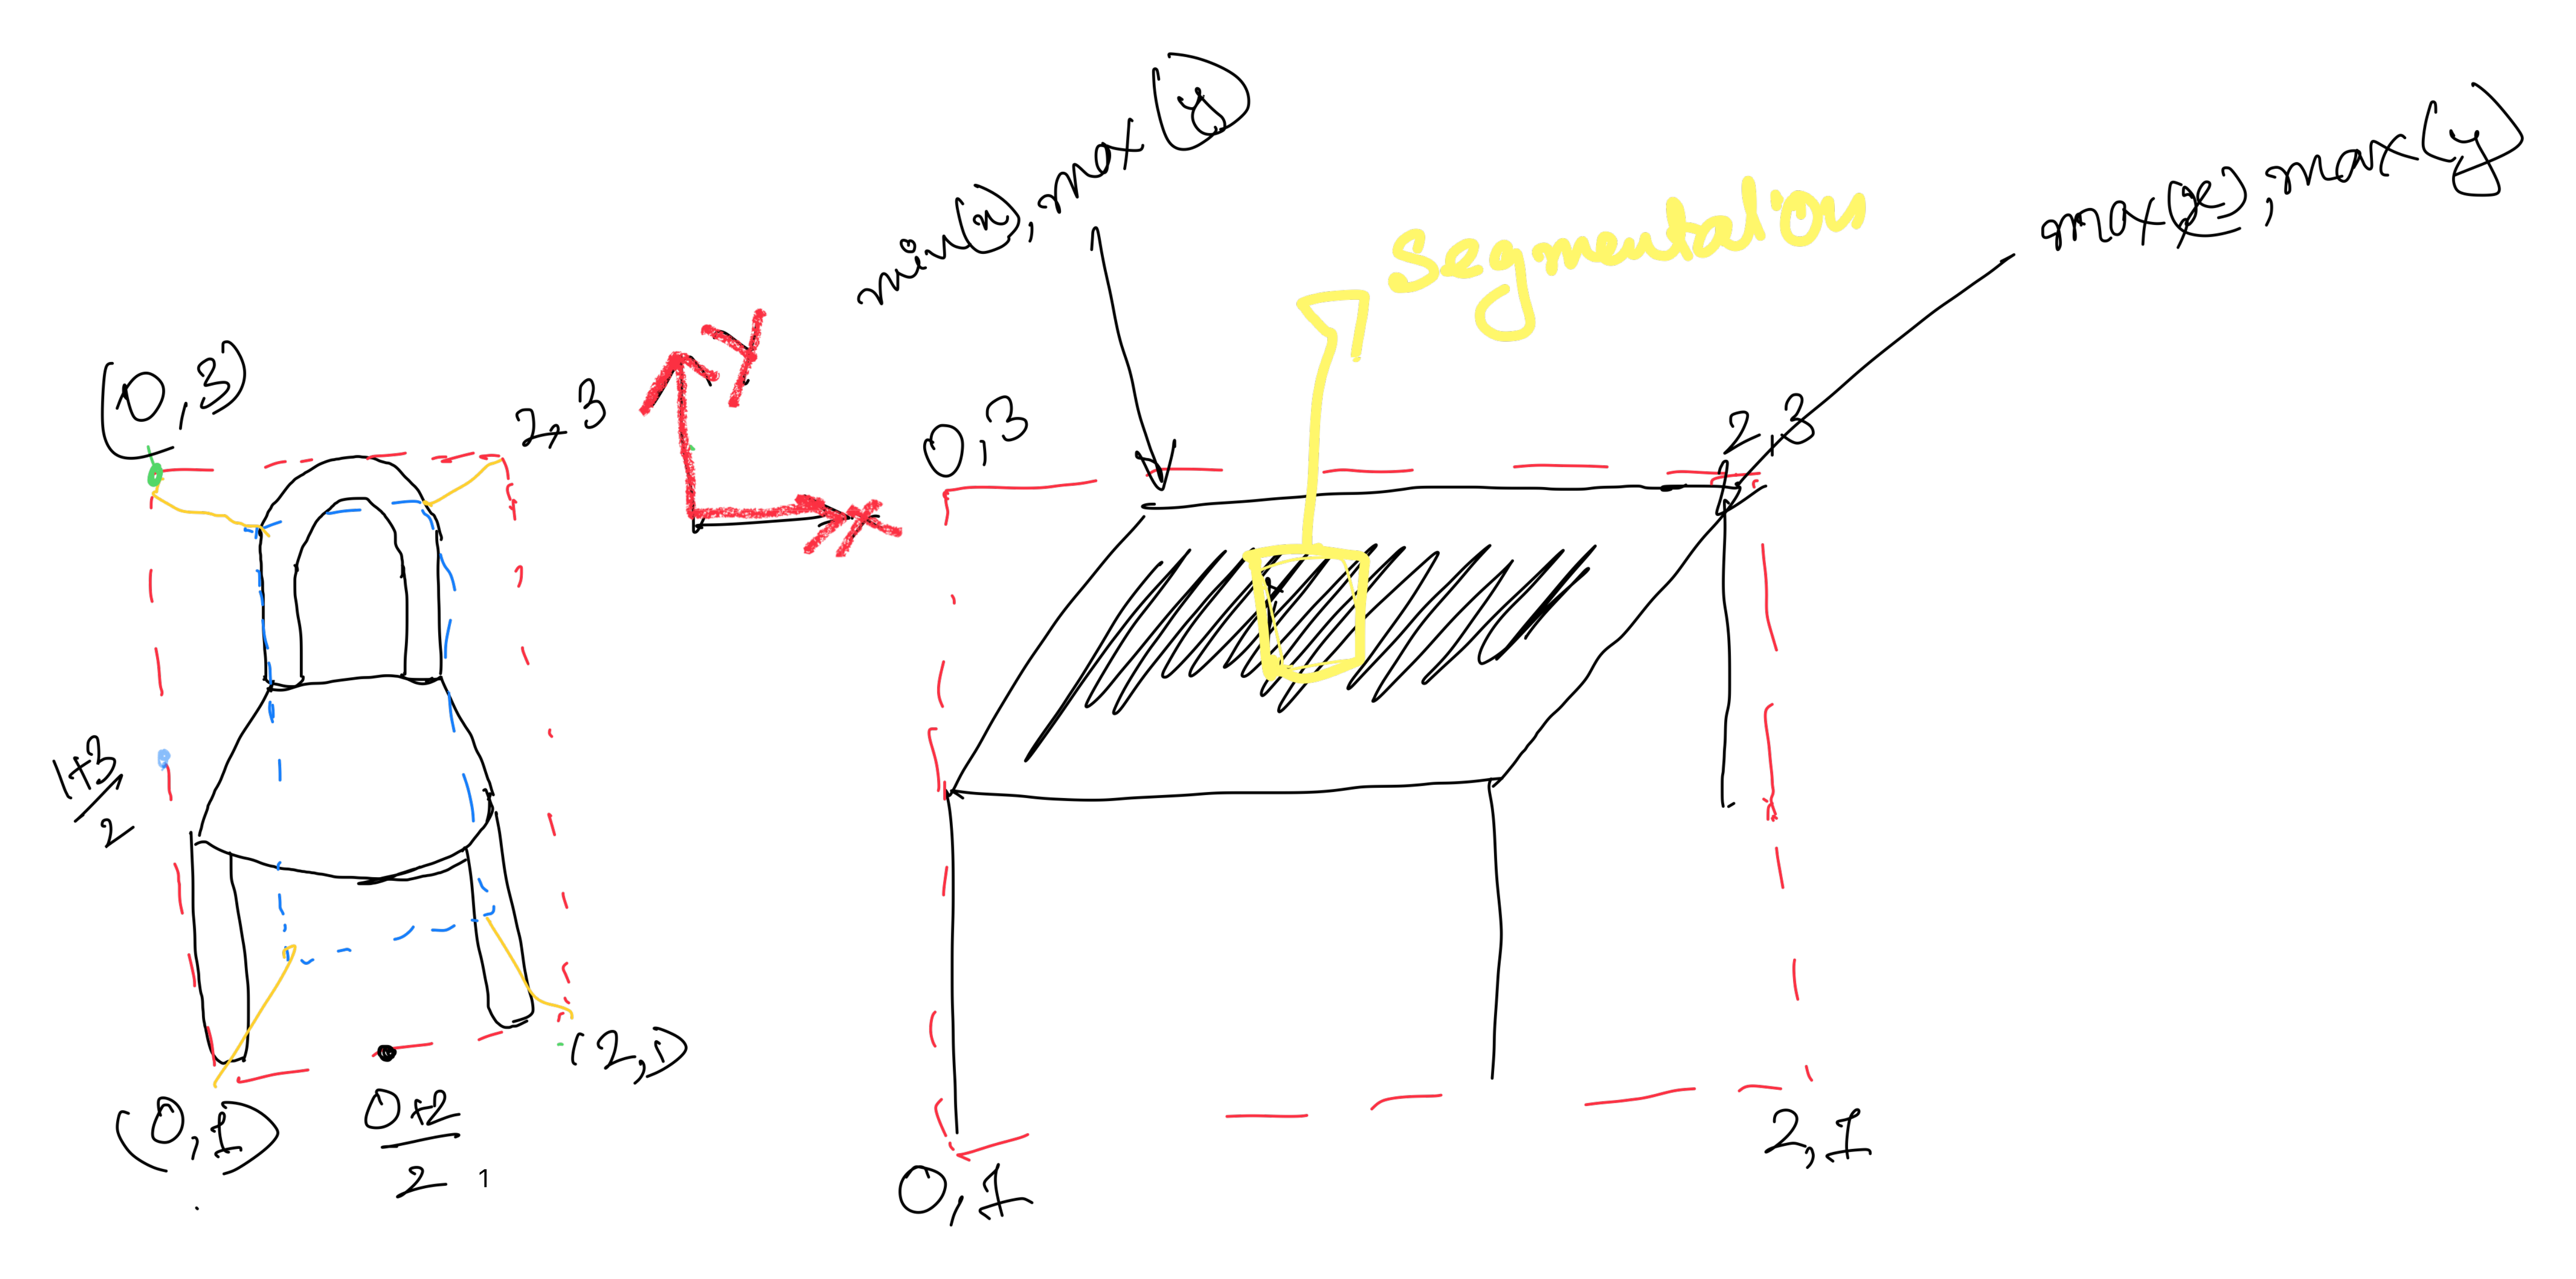

In [47]:
df = pd.DataFrame(data=data, columns=['Coord_1','Coord_2','Coord_3','Coord_4','Center_X', 'Center_Y', 'Depth','Background_depth', 'Confidence','Furniture_category'])
df

Coord_1     Coord_2     Coord_3     Coord_4 Center_X Center_Y     Depth  \
0  389.077698  138.013229  499.790771  311.263794    444.0    224.5  0.065773   
1  109.349747  169.690292  365.327454  374.265503    237.0    271.5  2.305032   
2  275.019409  139.518066   445.72644  301.271027    360.0    220.0  -0.26586   
3  351.419861   107.95256  445.303223  240.080551    398.0    174.0 -1.305859   
4  276.465393  112.103615  365.918823  210.060699    321.0    161.0 -0.866606   

  Background_depth Confidence Furniture_category  
0        -2.404071   0.658162                  1  
1        -2.404071   0.706893                  1  
2        -2.404071    0.61198                  1  
3        -2.404071   0.619808                  0  
4        -2.404071   0.518841                  0

Normalization of Center Co-ordinates

In [48]:
desired_min = -5
desired_max = 5
min_val = 0
max_val_x = source_image.width
max_val_y = source_image.height
ratio1 = desired_max-desired_min
df['Normalized_Center_X']= ((df['Center_X']-min_val)/(max_val_x-min_val))*(desired_max-desired_min) + desired_min
df['Normalized_Center_Y']= ((df['Center_Y']-min_val)/(max_val_y-min_val))*desired_max-desired_min + desired_min


In [49]:
cols = ['Coord_1','Coord_2','Coord_3','Coord_4','Center_X', 'Center_Y', 'Normalized_Center_X', 'Normalized_Center_Y','Depth','Background_depth', 'Confidence','Furniture_category']
df = df[cols]
df

Coord_1     Coord_2     Coord_3     Coord_4 Center_X Center_Y  \
0  389.077698  138.013229  499.790771  311.263794    444.0    224.5   
1  109.349747  169.690292  365.327454  374.265503    237.0    271.5   
2  275.019409  139.518066   445.72644  301.271027    360.0    220.0   
3  351.419861   107.95256  445.303223  240.080551    398.0    174.0   
4  276.465393  112.103615  365.918823  210.060699    321.0    161.0   

  Normalized_Center_X Normalized_Center_Y     Depth Background_depth  \
0                3.88            2.993333  0.065773        -2.404071   
1               -0.26                3.62  2.305032        -2.404071   
2                 2.2            2.933333  -0.26586        -2.404071   
3                2.96                2.32 -1.305859        -2.404071   
4                1.42            2.146667 -0.866606        -2.404071   

  Confidence Furniture_category  
0   0.658162                  1  
1   0.706893                  1  
2    0.61198                  1  
3   0.619808                  0  
4   0.518841                  0

In [50]:
df.to_json('RoomVisualization/Vr_Zoe.json', orient = 'index', indent = 2)